## 1. Get data ready

<h1><center>Step by step workflow:</center></h1>
<center><img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-pytorch-computer-vision-workflow.png" width=1000 height=550/></center>

In [1]:
# Source code: https://www.learnpytorch.io/03_pytorch_computer_vision/
import torchvision
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer 

# Evaluation metrics
from torchmetrics import Accuracy, ConfusionMatrix

import matplotlib.pyplot as plt
import pandas as pd

/Users/andresg/Documents/Personal_projects/PyTorch-Walkthrough/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/andresg/Documents/Personal_projects/PyTorch-Walkthrough/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define device
device = 'cpu'

# Define folder to save images
CNN_images_folder = './source_images/CNN'

# Download and save images
### The data comes in the following structure: image, target
train_data = torchvision.datasets.FashionMNIST(
    root=CNN_images_folder, 
    train=True,
    download=True,
    transform= torchvision.transforms.ToTensor())

test_data = torchvision.datasets.FashionMNIST(
    root=CNN_images_folder, 
    train=False,
    download=True,
    transform= torchvision.transforms.ToTensor())

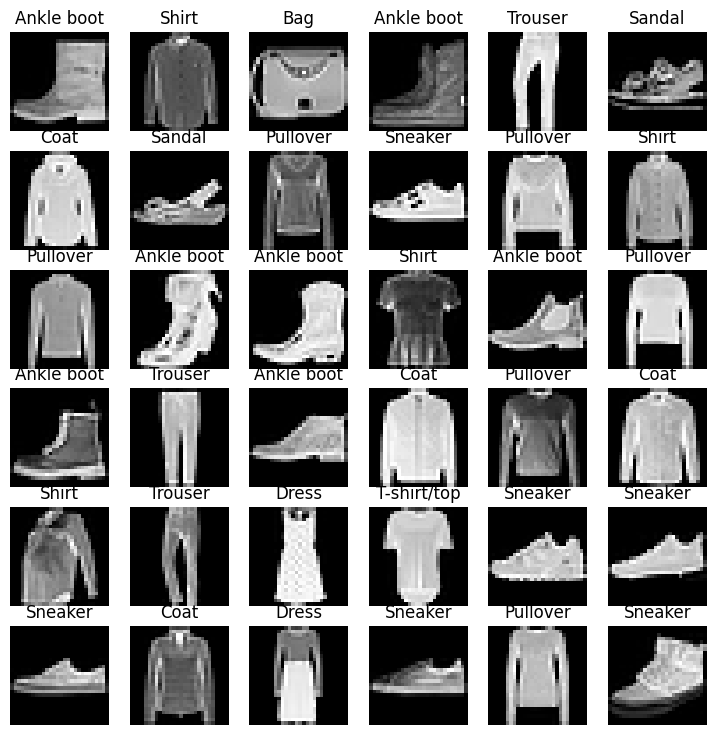

In [3]:
# Plot some examples
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 6,6
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(train_data.classes[label])
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis(False);

In [4]:
# Transform dataset from FashionMNIST to DataLoader with batches of 32 images for iteration purposes
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle= True,
                              collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle= True,
                              collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

## 2. Build model

In [5]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a sample
x, __ = train_data[0]

# Flatten the sample
output = flatten_model(x)

# Print output
print(f'Shape before flattening {x.shape} --> [Color channels, height, width]')
print(f'Shape after flattening {output.shape} --> [Color channels, height*width]')

Shape before flattening torch.Size([1, 28, 28]) --> [Color channels, height, width]
Shape after flattening torch.Size([1, 784]) --> [Color channels, height*width]


In [6]:
# Create baseline model
class FashionMNISTModelV0(nn.Module):
    # Constructor
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        # Define model
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # We send the images to a vector befor processing them into a model
            nn.Linear(in_features= input_shape, 
                      out_features= hidden_units),
            # nn.ReLU(),  --> For now not activation layers
            nn.Linear(in_features= hidden_units, 
                      out_features= output_shape),
        )
    # Create forward pass
    def forward(self, x):
        return self.layer_stack(x)

# Model parameters
IN_SHAPE = train_data[0][0].shape[1]*train_data[0][0].shape[2]
HIDD_UNITS = 10
OUT_SHAPE = len(train_data.classes)
    
# Instanciate model
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(
    input_shape= IN_SHAPE,
    hidden_units= HIDD_UNITS,
    output_shape= OUT_SHAPE 
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [7]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup Optimizer
optimizer = torch.optim.SGD(
    params = model_0.parameters(),
    lr = 0.1)

# Instanciate loss metrics
accuracy = Accuracy(task="multiclass", num_classes=OUT_SHAPE).to(device)

In [8]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

## 3. Train model

### 3.1 baseline NN model

In [9]:
%%time

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set number of epochs
epochs = 3

# Create training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    # Training loss per batch
    train_loss = 0
    
    # Training model
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        # Forward propagation
        model_0.train()
        # 1. Forward pass
        train_pred = model_0(X_train)
        # 2. Calculate loss (per batch)
        loss = loss_fn(train_pred, y_train)
        train_loss += loss  # accumulatively add up the loss per epoch 

        # Backward propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X_train)}/{len(train_dataloader.dataset)} samples")

    # Divide train loss by total of batches
    train_loss /= len(train_dataloader)

    # Testing model
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:

            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y_test) # accumulatively add up the loss per epoch

             # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy(test_pred.argmax(dim=1), y_test)
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)
        test_acc *= 100

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:02<00:04,  2.05s/it]


Train loss: 0.59039 | Test loss: 0.51016, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:04<00:02,  2.09s/it]


Train loss: 0.47435 | Test loss: 0.52677, Test acc: 81.68%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


Train loss: 0.45367 | Test loss: 0.51264, Test acc: 83.00%

Train time on cpu: 6.286 seconds
CPU times: user 5.98 s, sys: 882 ms, total: 6.86 s
Wall time: 6.3 s


In [10]:
def eval_model(
        model: nn.Module,
        test_dataloader: torch.utils.data.DataLoader,
        loss_fn: nn.Module,
        accuracy: Accuracy): 
    """ Method to evaluate model performance
    Args:
        model (nn.Module): Current model object
        test_dataloader (torch.utils.data.DataLoader): Iterable of the test set of images
        loss_fn (nn.Module): Model loss function
        accuracy (torchmetrics.Accuracy): Model accuracy function
    Return:
        Dictionary: Contains the results of the evaluation metrics
    """
    # Set seed
    torch.manual_seed(42)
    # Testing model
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in tqdm(test_dataloader):
            # Make predictions
            test_pred = model(X_test)

            # Accumulate metrics
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy(test_pred.argmax(dim=1), y_test)
        
        # Scale evaluation metrics
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    return {'model_name': model.__class__.__name__, # Only works when model was created with a class
            'model_loss': test_loss.item(),
            'model_acc': test_acc.item()}

In [11]:
# Calculate model_0 results
model_0_results = eval_model(
        model= model_0.to(device),
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:00<00:00, 1115.48it/s]


Essentially, **every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space**. 

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being *smaller* in size than the original values.

From an artificial intelligence perspective, you could consider the whole goal of a neural network to *compress* information.

![each layer of a neural network compresses the original input data into a smaller representation that is (hopefully) capable of making predictions on future input data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv-net-as-compression.png)

This means, that from the point of view of a neural network, intelligence is compression.

This is the idea of the use of a `nn.MaxPool2d()` layer: take the maximum value from a portion of a tensor and disregard the rest.

In essence, lowering the dimensionality of a tensor whilst still retaining a (hopefully) significant portion of the information.

It is the same story for a `nn.Conv2d()` layer.

Except instead of just taking the maximum, the `nn.Conv2d()` performs a convolutional operation on the data (see this in action on the [CNN Explainer webpage](https://poloclub.github.io/cnn-explainer/)).

### 3.2 Calibrated baseline NN model

In [12]:
# Define device
device = 'mps' if torch.has_mps else 'cpu'

# Create new model
class FashionMNISTModelV1(nn.Module):
    # Constructor
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        # Define model
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # We send the images to a vector befor processing them into a model
            nn.Linear(in_features= input_shape, 
                      out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, 
                      out_features= output_shape),
            nn.ReLU()
        )
    # Create forward pass
    def forward(self, x):
        return self.layer_stack(x)

# Instanciate model
model_1 = FashionMNISTModelV1(
                input_shape = IN_SHAPE,
                hidden_units= HIDD_UNITS,
                output_shape= OUT_SHAPE).to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup Optimizer
optimizer = torch.optim.SGD(
    params = model_1.parameters(),
    lr = 0.1)

# Instanciate loss metrics
accuracy = Accuracy(task="multiclass", num_classes=OUT_SHAPE).to(device)

### Setup helper functions for training

In [13]:
# Training helper function
def train_step(
    data_loader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy: Accuracy,
    device: torch.device = device):
    """ Performs training step on model trying to learn in data_loader"""
    # Training loss per batch
    train_loss, train_acc = 0, 0
    
    # Put model into training mode
    model.train()

    # Training model
    for batch, (X, y) in enumerate(data_loader):

        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward propagation
        train_pred = model(X)
        loss = loss_fn(train_pred, y)

        # Training metrics
        train_loss += loss
        train_acc += accuracy(train_pred.argmax(dim=1), y)

        # Backward propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Divide train loss by total of batches
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_acc *= 100
    print(f'Train_loss: {train_loss: .4f} | train_acc: {train_acc: .2f}%')

# Testing helper function
def test_step(
        data_loader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        accuracy: Accuracy,
        device: torch.device = device): 
    """ Performs testing step on model trying to evaluate in data_loader"""
    # Testing model
    test_loss, test_acc = 0, 0

    # Put model into evaluation mode
    model.eval()

    # Evaluate model
    with torch.inference_mode():
        for X, y in data_loader:

            # Send data to target device
            X, y = X.to(device), y.to(device)

            # Make predictions
            test_pred = model(X)

            # Accumulate metrics
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy(test_pred.argmax(dim=1), y)
        
        # Scale evaluation metrics
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_acc *= 100
        print(f'Test_loss: {test_loss: .4f} | test_acc: {test_acc: .2f}%')

In [14]:
%%time
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set number of epochs
epochs = 3

# Create training loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")

    # Training function
    train_step(
        data_loader= train_dataloader,
        model= model_1,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy= accuracy)

    # Testing function
    test_step(
        data_loader= test_dataloader,
        model= model_1,
        loss_fn= loss_fn,
        accuracy= accuracy)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

Epoch: 0
-------


/Users/andresg/Documents/Personal_projects/PyTorch-Walkthrough/venv/lib/python3.9/site-packages/torchmetrics/functional/classification/accuracy.py:77: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)


Train_loss:  0.6933 | train_acc:  75.74%
Test_loss:  0.5515 | test_acc:  80.59%
Epoch: 1
-------
Train_loss:  0.4959 | train_acc:  82.30%
Test_loss:  0.5709 | test_acc:  79.80%
Epoch: 2
-------
Train_loss:  0.4678 | train_acc:  83.29%
Test_loss:  0.5393 | test_acc:  81.67%
Train time on mps: 30.835 seconds
CPU times: user 19.4 s, sys: 2.31 s, total: 21.7 s
Wall time: 30.8 s


In [15]:
# Calculate model_1 results
model_1_results = eval_model(
        model= model_1,
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:01<00:00, 249.48it/s]


> **Note:** The training time on GPU vs CPU will depend largely on the quality of the CPU/GPU you're using. Read on for a more explained answer.
>
> **Question:** "I used a a GPU but my model didn't train faster, why might that be?"
>
> **Answer:** Well, one reason could be because your dataset and model are both so small (like the dataset and model we're working with) the benefits of using a GPU are outweighed by the time it actually takes to transfer the data there.
> 
> There's a small bottleneck between copying data from the CPU memory (default) to the GPU memory.
>
> So for smaller models and datasets, the CPU might actually be the optimal place to compute on.
>
> But for larger datasets and models, the speed of computing the GPU can offer usually far outweighs the cost of getting the data there.
>
> However, this is largely dependant on the hardware you're using. With practice, you will get used to where the best place to train your models is. 

### 3.3 Building a Convolutional Neural Network (CNN)

In [16]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    Model from CNN explainer Website
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # Instanciate CNN
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape, 
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units, 
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units,
                      out_channels= hidden_units,
                      kernel_size= 3,
                      stride= 1,
                      padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units*7*7, # Number of channels in our images dataset
                      out_features= output_shape)
        )

    # Forward Step
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

#  Define Image channels
IM_CHANNELS = train_data[0][0].shape[0]

# Inicialize the model
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape= IM_CHANNELS, 
                              hidden_units= HIDD_UNITS, 
                              output_shape= OUT_SHAPE).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [17]:
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [18]:
%%time
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set number of epochs
epochs = 3

# Create training loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")

    # Training function
    train_step(
        data_loader= train_dataloader,
        model= model_2,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy= accuracy)

    # Testing function
    test_step(
        data_loader= test_dataloader,
        model= model_2,
        loss_fn= loss_fn,
        accuracy= accuracy)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

Epoch: 0
-------
Train_loss:  0.5948 | train_acc:  78.32%
Test_loss:  0.4059 | test_acc:  85.34%
Epoch: 1
-------
Train_loss:  0.3582 | train_acc:  87.04%
Test_loss:  0.3833 | test_acc:  86.57%
Epoch: 2
-------
Train_loss:  0.3217 | train_acc:  88.42%
Test_loss:  0.3479 | test_acc:  87.86%
Train time on mps: 41.076 seconds
CPU times: user 27.6 s, sys: 3.35 s, total: 30.9 s
Wall time: 41.1 s


In [19]:
# Calculate model_2 results
model_2_results = eval_model(
        model= model_2.to(device),
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:01<00:00, 204.14it/s]


### Model 3 - Best model

In [20]:
# Inicialize the model
torch.manual_seed(42)
model_3 = FashionMNISTModelV2(input_shape= IM_CHANNELS, 
                              hidden_units= HIDD_UNITS, 
                              output_shape= OUT_SHAPE).to(device)
# Optimizer
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

model_3

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [21]:
%%time
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set number of epochs
epochs = 10

# Create training loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    # Training function
    train_step(
        data_loader= train_dataloader,
        model= model_3,
        loss_fn= loss_fn,
        optimizer= optimizer,
        accuracy= accuracy)

    # Testing function
    test_step(
        data_loader= test_dataloader,
        model= model_3,
        loss_fn= loss_fn,
        accuracy= accuracy)

# Calculate training time      
train_time_end_on_gpu = timer()
total_train_time_model_3 = print_train_time(start=train_time_start_on_gpu, 
                                           end=train_time_end_on_gpu,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train_loss:  0.5948 | train_acc:  78.32%


 10%|█         | 1/10 [00:13<02:03, 13.77s/it]

Test_loss:  0.4059 | test_acc:  85.34%
Epoch: 1
-------
Train_loss:  0.3582 | train_acc:  87.04%


 20%|██        | 2/10 [00:27<01:49, 13.70s/it]

Test_loss:  0.3833 | test_acc:  86.57%
Epoch: 2
-------
Train_loss:  0.3217 | train_acc:  88.42%


 30%|███       | 3/10 [00:41<01:37, 13.99s/it]

Test_loss:  0.3479 | test_acc:  87.86%
Epoch: 3
-------
Train_loss:  0.3002 | train_acc:  89.08%


 40%|████      | 4/10 [00:55<01:24, 14.07s/it]

Test_loss:  0.3100 | test_acc:  88.53%
Epoch: 4
-------
Train_loss:  0.2862 | train_acc:  89.56%


 50%|█████     | 5/10 [01:09<01:10, 14.02s/it]

Test_loss:  0.3180 | test_acc:  88.55%
Epoch: 5
-------
Train_loss:  0.2739 | train_acc:  89.99%


 60%|██████    | 6/10 [01:23<00:55, 13.99s/it]

Test_loss:  0.3018 | test_acc:  89.26%
Epoch: 6
-------
Train_loss:  0.2683 | train_acc:  90.30%


 70%|███████   | 7/10 [01:37<00:41, 13.97s/it]

Test_loss:  0.3132 | test_acc:  89.13%
Epoch: 7
-------
Train_loss:  0.2606 | train_acc:  90.65%


 80%|████████  | 8/10 [01:51<00:27, 13.99s/it]

Test_loss:  0.3106 | test_acc:  88.63%
Epoch: 8
-------
Train_loss:  0.2561 | train_acc:  90.71%


 90%|█████████ | 9/10 [02:05<00:13, 13.96s/it]

Test_loss:  0.2856 | test_acc:  89.72%
Epoch: 9
-------
Train_loss:  0.2506 | train_acc:  90.86%


100%|██████████| 10/10 [02:19<00:00, 13.95s/it]

Test_loss:  0.2839 | test_acc:  90.05%
Train time on mps: 139.548 seconds
CPU times: user 1min 33s, sys: 11.9 s, total: 1min 45s
Wall time: 2min 19s


In [22]:
# Calculate model_3 results
model_3_results = eval_model(
        model= model_3.to(device),
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

100%|██████████| 313/313 [00:01<00:00, 195.89it/s]


In [23]:
model_3_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2844724953174591,
 'model_acc': 0.9001597166061401}

<p> Compare results on models:</p>

In [24]:
compare_results = pd.DataFrame([
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results])

compare_results['Training_time'] = [round(total_train_time_model_0,2),
                                    round(total_train_time_model_1,2),
                                    round(total_train_time_model_2,2),
                                    round(total_train_time_model_3,2)]

compare_results

,model_name,model_loss,model_acc,Training_time
0,FashionMNISTModelV0,0.512530,0.830072,6.29
1,FashionMNISTModelV1,0.539148,0.816593,30.84
2,FashionMNISTModelV2,0.347899,0.878694,41.08
3,FashionMNISTModelV2,0.284472,0.900160,139.55


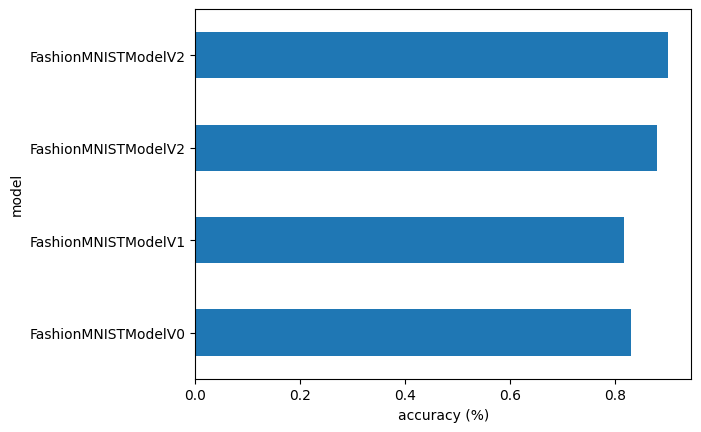

In [25]:
# Visualize model results
compare_results.set_index('model_name')['model_acc'].plot(kind='barh')
plt.xlabel('accuracy (%)')
plt.ylabel('model');

## 4. Make Predictions

In [26]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    # Set the model in evaluation mode
    model.eval()
    # Make predictions
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (Add a batch dim and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (get logits)
            pred_logit = model(sample)

            # Get pred probabilities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Send predictions to CPU for further use
            pred_probs.append(pred_prob.cpu())
    # Stack pred_probs into a tensor and return
    return torch.stack(pred_probs)

In [27]:
#  Get random list of test samples
import random
# random.seed(42)
test_samples= []
test_labels= []

# Iterate test_data and extract random samples and labels
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

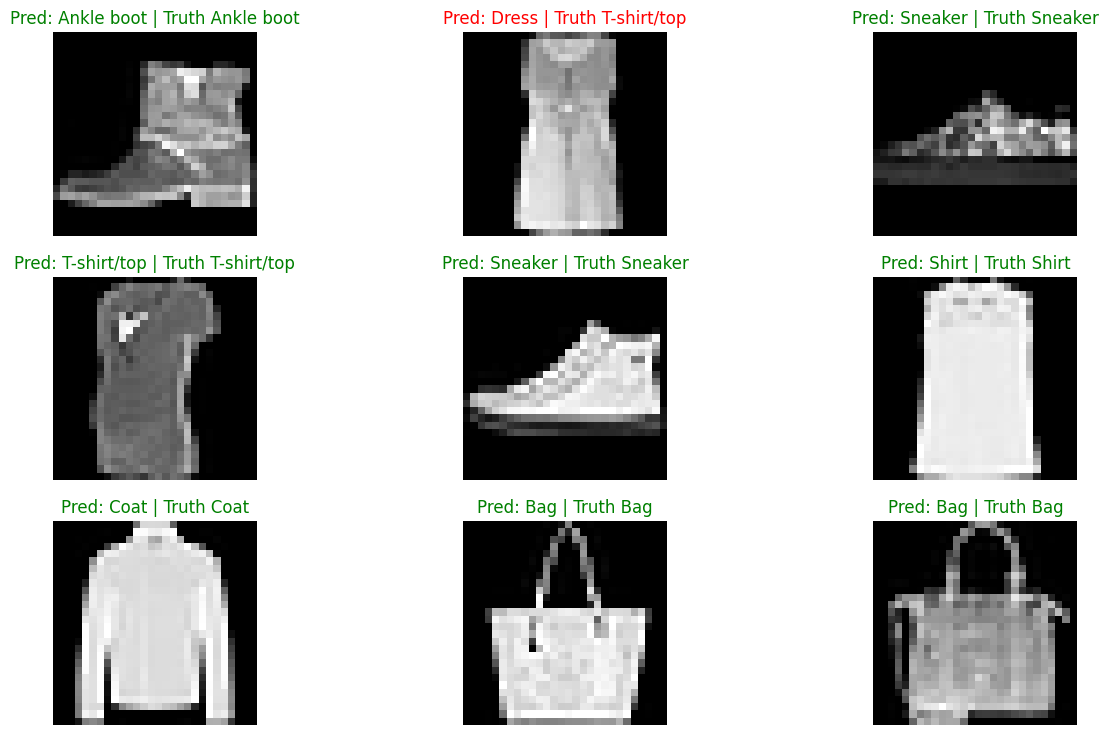

In [28]:
# Make predictions
pred_labels = make_predictions(model_3, test_samples).argmax(dim=1)

# Plot examples
fig = plt.figure(figsize=(15,9))
rows, cols = 3,3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(rows, cols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap='gray')

    # Find the prediction (Text)
    pred_label = test_data.classes[pred_labels[i]]

    # Get truth label (Text)
    truth_label = test_data.classes[test_labels[i]]

    # Plot title
    title_text = f"Pred: {pred_label} | Truth {truth_label}"

    # Check for eqality between pred and truth
    if pred_label == truth_label:
        plt.title(title_text, c='g')
    else:
        plt.title(title_text, c='r')

    plt.axis(False);

In [30]:
test_samples= []
test_labels= []

# Iterate test_data and extract samples and labels
for sample, label in test_data:
    test_samples.append(sample)
    test_labels.append(label)

# Make predictions
pred_labels = torch.tensor(make_predictions(model_3, test_samples).argmax(dim=1))
test_labels = torch.tensor(test_labels)

/var/folders/5v/mt404vm51mvcpt_t2j5z7dbm0000gn/T/ipykernel_26456/1715221823.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_labels = torch.tensor(make_predictions(model_3, test_samples).argmax(dim=1))


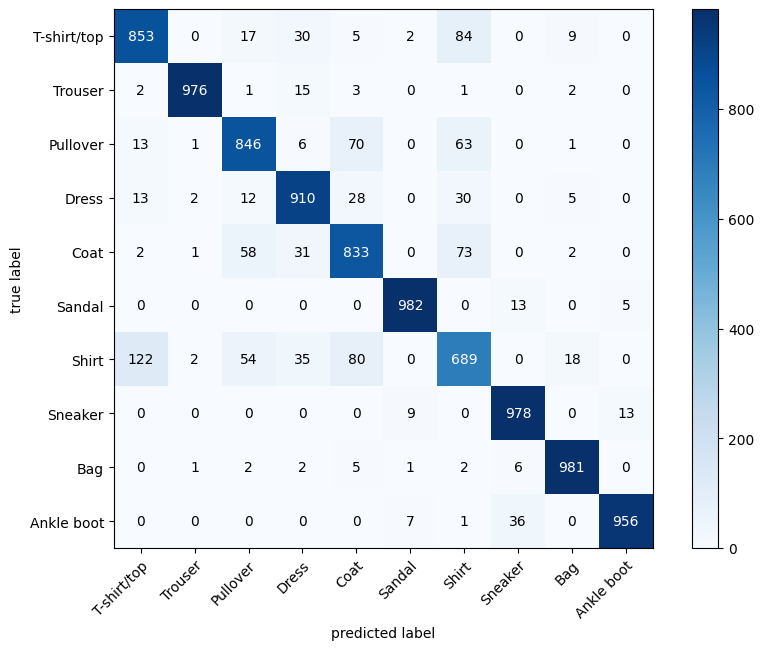

In [49]:
# https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/
from mlxtend.plotting import plot_confusion_matrix

# Confusion Matrix
cm = ConfusionMatrix(task="multiclass", num_classes=OUT_SHAPE)
multiclass = cm(pred_labels, test_labels)

fig, ax = plot_confusion_matrix(conf_mat=multiclass.numpy(),
                                colorbar=True,
                                class_names= test_data.classes,
                                figsize=(10,7))

plt.show()

### 5. Save and load best performance model

In [51]:
import os 

# Set folder and model name
folder_name = '../models'
model_name = 'CNNModel.pth'

# Create folder if does not exist
if not os.path.exists(folder_name):
    os.mkdir(folder_name)

# Define path and save model state parameters
model_path = os.path.join(folder_name, model_name)
torch.save(obj=model_3.state_dict(), f=model_path)

In [52]:
# Load the pytorch model

# Create a new instance of the model
torch.manual_seed(42)
CNN_model = FashionMNISTModelV2(input_shape= IM_CHANNELS, 
                              hidden_units= HIDD_UNITS, 
                              output_shape= OUT_SHAPE).to(device)

# Load model state
state_dict = torch.load(model_path)

# Update model parameters
CNN_model.load_state_dict(state_dict)

CNN_model

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Evaluate loaded model
loaded_model_results = eval_model(
        model= CNN_model,
        test_dataloader= test_dataloader,
        loss_fn= loss_fn,
        accuracy= accuracy)

In [58]:
# Check if models evaluations are close
torch.isclose(
        torch.tensor(model_3_results['model_loss']), 
        torch.tensor(loaded_model_results['model_loss']),
        atol=1e-02)

tensor(True)